## Step 0: Set up environment


In [ ]:
!git clone https://github.com/ActiveVisionLab/nerfmm.git

Cloning into 'nerfmm'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 100 (delta 2), reused 1 (delta 0), pack-reused 94
Receiving objects: 100% (100/100), 82.80 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image
from google.colab import files

In [ ]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from nerfmm.utils.pos_enc import encode_position
from nerfmm.utils.volume_op import volume_rendering, volume_sampling_ndc
from nerfmm.utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# utlities
from nerfmm.utils.training_utils import mse2psnr
from nerfmm.utils.lie_group_helper import convert3x4_4x4

In [ ]:
# get prepared example scenes
!wget https://www.robots.ox.ac.uk/~ryan/nerfmm2021/nerfmm_colab_data.tar.gz

# extract and clean storage
!tar xzf nerfmm_colab_data.tar.gz
!rm nerfmm_colab_data.tar.gz

--2024-08-11 07:01:23--  https://www.robots.ox.ac.uk/~ryan/nerfmm2021/nerfmm_colab_data.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25803698 (25M) [application/x-gzip]
Saving to: ‘nerfmm_colab_data.tar.gz’

nerfmm_colab_data.t 100%[===================>]  24.61M  84.7MB/s    in 0.3s    

2024-08-11 07:01:23 (84.7 MB/s) - ‘nerfmm_colab_data.tar.gz’ saved [25803698/25803698]



In [ ]:
scene_name = input('Pick a scene: (llff_flower / llff_leaves / desk / upload) ')
print('Selected scene: ', scene_name)
if scene_name in ['llff_flower', 'llff_leaves', 'desk']:
    image_dir = os.path.join('nerfmm_colab_data', scene_name)
elif scene_name == 'upload':
    try:
        !rm -rf 'custom_upload'

        uploaded = files.upload()
        up_file_name = list(uploaded.keys())[0]
        print('Uploaded file "{name}" with size ~{length} MB'.format(name=up_file_name, length=len(uploaded[up_file_name])/1e6))

        !mv $up_file_name 'custom_upload.zip'
        !unzip 'custom_upload.zip' -d 'custom_upload'
        !rm 'custom_upload.zip'
        image_dir = os.path.join('custom_upload', os.listdir('custom_upload')[0])
        print('Upload and unzip done.')
    except:
        print('Seems like upload failed. Please retry.')
else:
    scene_name = 'llff_flower'
    image_dir = os.path.join('nerfmm_colab_data', scene_name)
    print('Unknown scene name. Using llff_flower scene.')


Pick a scene: (llff_flower / llff_leaves / desk / upload) llff_flower
Selected scene:  llff_flower


## Step 1b: Load images

<ipython-input-9-b5babcb90bd2>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8


Loaded 34 imgs, resolution 756 x 1008
torch.Size([34, 756, 1008, 3])


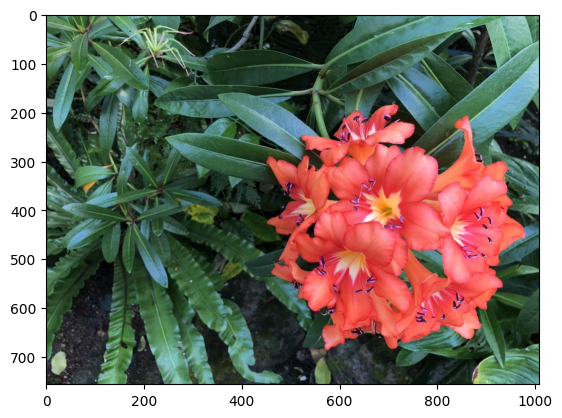

In [ ]:
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]

    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs(image_dir)
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
plt.imshow(imgs[0])

## Step 2a: Define learnable FOCALS

We initialise $f_x = W$ and $f_y = H$.


In [ ]:
class LearnFocal(nn.Module):
    def __init__(self, H, W, req_grad):
        super(LearnFocal, self).__init__()
        self.H = H
        self.W = W
        self.fx = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)  # (1, )
        self.fy = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)  # (1, )

    def forward(self):
        # order = 2, check our supplementary.
        fxfy = torch.stack([self.fx**2 * self.W, self.fy**2 * self.H])
        return fxfy

## Step 2b: Define learnable POSES



In [ ]:
def vec2skew(v):
    """
    :param v:  (3, ) torch tensor
    :return:   (3, 3)
    """
    zero = torch.zeros(1, dtype=torch.float32, device=v.device)
    skew_v0 = torch.cat([ zero,    -v[2:3],   v[1:2]])  # (3, 1)
    skew_v1 = torch.cat([ v[2:3],   zero,    -v[0:1]])
    skew_v2 = torch.cat([-v[1:2],   v[0:1],   zero])
    skew_v = torch.stack([skew_v0, skew_v1, skew_v2], dim=0)  # (3, 3)
    return skew_v  # (3, 3)


def Exp(r):
    """so(3) vector to SO(3) matrix
    :param r: (3, ) axis-angle, torch tensor
    :return:  (3, 3)
    """
    skew_r = vec2skew(r)  # (3, 3)
    norm_r = r.norm() + 1e-15
    eye = torch.eye(3, dtype=torch.float32, device=r.device)
    R = eye + (torch.sin(norm_r) / norm_r) * skew_r + ((1 - torch.cos(norm_r)) / norm_r**2) * (skew_r @ skew_r)
    return R


def make_c2w(r, t):
    """
    :param r:  (3, ) axis-angle             torch tensor
    :param t:  (3, ) translation vector     torch tensor
    :return:   (4, 4)
    """
    R = Exp(r)  # (3, 3)
    c2w = torch.cat([R, t.unsqueeze(1)], dim=1)  # (3, 4)
    c2w = convert3x4_4x4(c2w)  # (4, 4)
    return c2w


class LearnPose(nn.Module):
    def __init__(self, num_cams, learn_R, learn_t):
        super(LearnPose, self).__init__()
        self.num_cams = num_cams
        self.r = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_R)  # (N, 3)
        self.t = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_t)  # (N, 3)

    def forward(self, cam_id):
        r = self.r[cam_id]  # (3, ) axis-angle
        t = self.t[cam_id]  # (3, )
        c2w = make_c2w(r, t)  # (4, 4)
        return c2w

## Step 2c: Define a tiny NeRF


In [ ]:
class TinyNerf(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(TinyNerf, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )

        self.fc_density = nn.Linear(D, 1)
        self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3)

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        density = self.fc_density(x)  # (H, W, N_sample, 1)

        feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([feat, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den

## Step 3: Training pipeline

### Set ray parameters

In [ ]:
class RayParameters():
    def __init__(self):
      self.NEAR, self.FAR = 0.0, 1.0  # ndc near far
      self.N_SAMPLE = 128  # samples per ray
      self.POS_ENC_FREQ = 10  # positional encoding freq for location
      self.DIR_ENC_FREQ = 4 # positional encoding freq for direction

ray_params = RayParameters()

### Define training function


In [ ]:
def model_render_image(c2w, rays_cam, t_vals, ray_params, H, W, fxfy, nerf_model,
                       perturb_t, sigma_noise_std):
    """
    :param c2w:         (4, 4)                  pose to transform ray direction from cam to world.
    :param rays_cam:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                rows and cols, or some full rows, or an entire image.
    :param t_vals:      (N_samples)             sample depth along a ray.
    :param perturb_t:   True/False              perturb t values.
    :param sigma_noise_std: float               add noise to raw density predictions (sigma).
    :return:            (someH, someW, 3)       volume rendered images for the input rays.
    """
    # KEY 2: sample the 3D volume using estimated poses and intrinsics online.
    # (H, W, N_sample, 3), (H, W, 3), (H, W, N_sam)
    sample_pos, _, ray_dir_world, t_vals_noisy = volume_sampling_ndc(c2w, rays_cam, t_vals, ray_params.NEAR,
                                                                     ray_params.FAR, H, W, fxfy, perturb_t)

    # encode position: (H, W, N_sample, (2L+1)*C = 63)
    pos_enc = encode_position(sample_pos, levels=ray_params.POS_ENC_FREQ, inc_input=True)

    # encode direction: (H, W, N_sample, (2L+1)*C = 27)
    ray_dir_world = F.normalize(ray_dir_world, p=2, dim=2)  # (H, W, 3)
    dir_enc = encode_position(ray_dir_world, levels=ray_params.DIR_ENC_FREQ, inc_input=True)  # (H, W, 27)
    dir_enc = dir_enc.unsqueeze(2).expand(-1, -1, ray_params.N_SAMPLE, -1)  # (H, W, N_sample, 27)

    # inference rgb and density using position and direction encoding.
    rgb_density = nerf_model(pos_enc, dir_enc)  # (H, W, N_sample, 4)

    render_result = volume_rendering(rgb_density, t_vals_noisy, sigma_noise_std, rgb_act_fn=torch.sigmoid)
    rgb_rendered = render_result['rgb']  # (H, W, 3)
    depth_map = render_result['depth_map']  # (H, W)

    result = {
        'rgb': rgb_rendered,  # (H, W, 3)
        'depth_map': depth_map,  # (H, W)
    }

    return result


def train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                    opt_pose, nerf_model, focal_net, pose_param_net):
    nerf_model.train()
    focal_net.train()
    pose_param_net.train()

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position
    L2_loss_epoch = []

    # shuffle the training imgs
    ids = np.arange(N_IMGS)
    np.random.shuffle(ids)

    for i in ids:
        fxfy = focal_net()

        # KEY 1: compute ray directions using estimated intrinsics online.
        ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
        img = imgs[i].to('cuda')  # (H, W, 4)
        c2w = pose_param_net(i)  # (4, 4)

        # sample 32x32 pixel on an image and their rays for training.
        r_id = torch.randperm(H, device='cuda')[:32]  # (N_select_rows)
        c_id = torch.randperm(W, device='cuda')[:32]  # (N_select_cols)
        ray_selected_cam = ray_dir_cam[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)
        img_selected = img[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)

        # render an image using selected rays, pose, sample intervals, and the network
        render_result = model_render_image(c2w, ray_selected_cam, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=True, sigma_noise_std=0.0)
        rgb_rendered = render_result['rgb']  # (N_select_rows, N_select_cols, 3)
        L2_loss = F.mse_loss(rgb_rendered, img_selected)  # loss for one image

        L2_loss.backward()
        opt_nerf.step()
        opt_focal.step()
        opt_pose.step()
        opt_nerf.zero_grad()
        opt_focal.zero_grad()
        opt_pose.zero_grad()

        L2_loss_epoch.append(L2_loss)

    L2_loss_epoch_mean = torch.stack(L2_loss_epoch).mean().item()
    return L2_loss_epoch_mean

### Define evaluation function


In [ ]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model,
                                           perturb_t=False, sigma_noise_std=0.0)
        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

## Step 4: Actual training ⚽



In [ ]:
N_EPOCH = 5000 # set to 1000 to get slightly better results.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a tiny NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')


Training... Check results in the tensorboard above.


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch    0 Training PSNR 12.070, estimated fx 1009.0 fy 757.9
epoch    1 Training PSNR 12.769, estimated fx 1011.4 fy 763.7
epoch    2 Training PSNR 12.934, estimated fx 1011.9 fy 774.0
epoch    3 Training PSNR 13.154, estimated fx 1001.6 fy 793.4
epoch    4 Training PSNR 13.222, estimated fx 1014.3 fy 797.7
epoch    5 Training PSNR 13.317, estimated fx 1042.6 fy 822.9
epoch    6 Training PSNR 13.247, estimated fx 1070.0 fy 839.8
epoch    7 Training PSNR 13.473, estimated fx 1114.0 fy 838.7
epoch    8 Training PSNR 13.603, estimated fx 1164.4 fy 851.2
epoch    9 Training PSNR 13.686, estimated fx 1233.0 fy 870.6
epoch   10 Training PSNR 13.925, estimated fx 1294.1 fy 895.7
epoch   11 Training PSNR 14.185, estimated fx 1375.3 fy 927.7
epoch   12 Training PSNR 14.510, estimated fx 1448.1 fy 954.7
epoch   13 Training PSNR 14.753, estimated fx 1521.6 fy 978.9
epoch   14 Training PSNR 15.011, estimated fx 1534.1 fy 989.1
epoch   15 Training PSNR 15.425, estimated fx 1572.8 fy 995.7
epoch   

In [ ]:
output_folder = 'enhanced_images'
os.makedirs(output_folder, exist_ok=True)

rendered_img_list = []  # List to store rendered images

with torch.no_grad():
    nerf_model.eval()
    fxfy = focal_net()

    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])

    for i in range(N_IMGS):
        c2w = optimised_poses[i].cuda()

        split_size = len(ray_dir_cam) // N_IMGS
        rays_dir_cam_split_rows = ray_dir_cam.split(split_size, dim=0)
        # rays_dir_cam_split_rows = ray_dir_cam.split(16, dim=0)  # Split the rays into chunks

        enh_img_list, enh_depth_list = [], []

        for rays_dir_rows in rays_dir_cam_split_rows:
            render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                               H, W, fxfy, nerf_model, perturb_t=False, sigma_noise_std=0.0)
            rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
            depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

            enh_img_list.append(rgb_rendered_rows)
            enh_depth_list.append(depth_map)

        # Concatenate rendered images and depth maps
        rendered_img = torch.cat(enh_img_list, dim=0)  # (H * num_images, W, 3)
        rendered_depth = torch.cat(enh_depth_list, dim=0)  # (H * num_images, W)

        # Convert to numpy arrays for visualization
        rendered_img_np = (rendered_img.cpu().numpy() * 255).astype(np.uint8)
        rendered_depth_np = (rendered_depth.cpu().numpy() * 200).astype(np.uint8)

        # Save the enhanced images
        image_filename = f'image_{i:03d}.png'
        imageio.imwrite(os.path.join(output_folder, image_filename), rendered_img_np)

        # Append rendered image to the list
        rendered_img_list.append(rendered_img_np)

print('Enhanced images saved.')

# Convert the list of rendered images to a numpy array for creating GIF
rendered_img_array = np.array(rendered_img_list)


NeRF trained in 270 x 480 for 2000 epochs
Enhanced images saved.


In [ ]:
import imageio

# Define the output file path for the GIF
gif_output_path = 'rendered_images.gif'

# Create the GIF using imageio
imageio.mimsave(gif_output_path, rendered_img_list, duration=0.1)  # Adjust duration as needed

print(f'GIF created and saved at: {gif_output_path}')


GIF created and saved at: rendered_images.gif


In [ ]:
Image(open(os.path.join('rendered_images.gif'), 'rb').read())

In [ ]:
with torch.no_grad():
   nerf_model.eval()
   fxfy = focal_net()

   optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
   c2w = c2w.to('cuda')

   print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))

   t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')

   ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
   rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time

   enh_img_list, enh_depth_list = [], []
   rendered_img = []
   rendered_depth = []
   for rays_dir_rows in rays_dir_cam_split_rows:
         render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=False, sigma_noise_std=0.0)
         rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
         depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

         rendered_img.append(rgb_rendered_rows)
         rendered_depth.append(depth_map)

   rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
   rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)

   enh_img_list.append(rendered_img)
   enh_depth_list.append(rendered_depth)


   print(' Enhanced view rendering done. Saving to GIF images...')
   enh_img_list = (torch.stack(enh_img_list) * 255).cpu().numpy().astype(np.uint8)
   enh_depth_list = (torch.stack(enh_depth_list) * 200).cpu().numpy().astype(np.uint8)
   os.makedirs('nvs_results', exist_ok=True)
   imageio.mimwrite(os.path.join('nvs_results', scene_name + '_img.gif'), enh_img_list, fps=30)
   imageio.mimwrite(os.path.join('nvs_results', scene_name + '_depth.gif'), enh_depth_list, fps=30)
   print('GIF images saved.')

## Step 5: Novel View Synthesis

In [ ]:

from nerfmm.utils.pose_utils import create_spiral_poses

resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)


    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')

NeRF trained in 756 x 1008 for 1000 epochs
Rendering novel views in 189 x 252


novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

Novel view rendering done. Saving to GIF images...


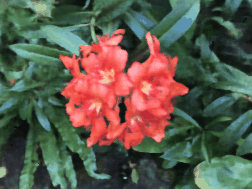

In [ ]:
Image(open(os.path.join('nvs_results', scene_name + '_img.gif'), 'rb').read())

In [ ]:
import shutil
# Define the local folder path within Colab
local_folder_path = "/content/novel_views_generated"

print('Novel view rendering done. Saving images...')

# Create the local folder
os.makedirs(local_folder_path, exist_ok=True)

for i in range(30):
    plt.imshow(novel_img_list[i])
    plt.savefig(os.path.join(local_folder_path, f'novel_view_{i+1}.png'))
    plt.clf()  # Clear the current figure to avoid overlapping images

print(f'Novel views saved as images in {local_folder_path}.')

# ... (remaining code)

# Create a zip archive
shutil.make_archive("/content/novel_views_generated", 'zip', local_folder_path)

# Move the zip archive to the current working directory
shutil.move("/content/novel_views_generated.zip", "/content/novel_views_generated.zip")

print('Zip archive created. Downloading...')

# Provide a link to download the zip archive
from google.colab import files

files.download("/content/novel_views_generated.zip")

Novel view rendering done. Saving images...
Novel views saved as images in /content/novel_views_generated.
Zip archive created. Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

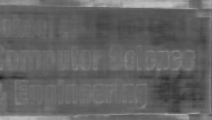

In [ ]:
Image(open(os.path.join('nvs_results', scene_name + '_depth.gif'), 'rb').read())

## Step 6: Visualise Camera Poses 📷



In [ ]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
ax0 = plt.subplot(111)
ax0.set_xlim((-0.5, 0.5))
ax0.set_ylim((-0.5, 0.5))
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.grid(ls='--', color='0.7')

title = ax0.set_title('')
traj_line, = ax0.plot([], [], c='blue', ls='-', marker='^', linewidth=0.7, markersize=4)

def drawframe(fr_id):
    """
    :param fr_id: frame id
    :param poses: (N_img, 3) camera positions
    """
    poses = pose_history[fr_id]
    traj_line.set_data(poses[:, 0], poses[:, 1])
    title.set_text('epoch {0:4d}'.format(fr_id))
    return (traj_line,)

anim = animation.FuncAnimation(fig, drawframe, frames=N_EPOCH, interval=100)

plt.close(anim._fig)
HTML(anim.to_html5_video())